This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/wallaroo2024.3_tutorials/wallaroo-observe/houseprice-saga).

## House Price Testing Life Cycle Comprehensive Tutorial

This tutorial simulates using Wallaroo for testing a model for inference outliers, potential model drift, and methods to test competitive models against each other and deploy the final version to use.  This demonstrates using assays to detect model or data drift, then Wallaroo Shadow Deploy to compare different models to determine which one is most fit for an organization's needs.  These features allow organizations to monitor model performance and accuracy then swap out models as needed.

* **IMPORTANT NOTE**: This tutorial assumes that the House Price Model Life Cycle Preparation notebook was run before this notebook, and that the workspace, pipeline and models used are the same.  This is **critical** for the section on Assays below.  If the preparation notebook has not been run, skip the Assays section as there will be no historical data for the assays to function on.

This tutorial will demonstrate how to:

1. Select or create a workspace, pipeline and upload the champion model.
1. Add a pipeline step with the champion model, then deploy the pipeline and perform sample inferences.
1. Create an assay and set a baseline, then demonstrate inferences that trigger the assay alert threshold.
1. Swap out the pipeline step with the champion model with a shadow deploy step that compares the champion model against two competitors.
1. Evaluate the results of the champion versus competitor models.
1. Change the pipeline step from a shadow deploy step to an A/B testing step, and show the different results.
1. Change the A/B testing step back to standard pipeline step with the original control model, then demonstrate hot swapping the control model with a challenger model without undeploying the pipeline.
1. Undeploy the pipeline.

This tutorial provides the following:

* Models:
  * `models/rf_model.onnx`: The champion model that has been used in this environment for some time.
  * `models/xgb_model.onnx` and `models/gbr_model.onnx`: Rival models that will be tested against the champion.
* Data:
  * `data/xtest-1.df.json` and `data/xtest-1k.df.json`:  DataFrame JSON inference inputs with 1 input and 1,000 inputs.
  * `data/xtest-1k.arrow`:  Apache Arrow inference inputs with 1 input and 1,000 inputs.

## Prerequisites

* A deployed Wallaroo instance
* The following Python libraries installed:
  * [`wallaroo`](https://pypi.org/project/wallaroo/): The Wallaroo SDK. Included with the Wallaroo JupyterHub service by default.
  * [`pandas`](https://pypi.org/project/pandas/): Pandas, mainly used for Pandas DataFrame

## Initial Steps

### Import libraries

The first step is to import the libraries needed for this notebook.

In [1]:
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

from IPython.display import display

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

import datetime
import time

import json

### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [2]:
# Login through local Wallaroo instance

wl = wallaroo.Client()

### Create Workspace

We will create a workspace to manage our pipeline and models.  The following variables will set the name of our sample workspace then set it as the current workspace.

Workspace, pipeline, and model names should be unique to each user, so we'll add in a randomly generated suffix so multiple people can run this tutorial in a Wallaroo instance without effecting each other.

In [3]:
workspace_name = f'housepricesagaworkspace'
main_pipeline_name = f'housepricesagapipeline'
model_name_control = f'housepricesagacontrol'
model_file_name_control = './models/rf_model.onnx'

In [4]:
workspace = wl.get_workspace(name=workspace_name, create_if_not_exist=True)

wl.set_current_workspace(workspace)

{'name': 'housepricesagaworkspace', 'id': 11, 'archived': False, 'created_by': 'fb2916bc-551e-4a76-88e8-0f7d7720a0f9', 'created_at': '2024-07-29T20:53:30.833194+00:00', 'models': [{'name': 'housepricesagacontrol', 'versions': 1, 'owner_id': '""', 'last_update_time': datetime.datetime(2024, 7, 29, 20, 53, 34, 55901, tzinfo=tzutc()), 'created_at': datetime.datetime(2024, 7, 29, 20, 53, 34, 55901, tzinfo=tzutc())}], 'pipelines': [{'name': 'housepricesagapipeline', 'create_time': datetime.datetime(2024, 7, 29, 20, 54, 17, 194002, tzinfo=tzutc()), 'definition': '[]'}]}

### Upload The Champion Model

For our example, we will upload the champion model that has been trained to derive house prices from a variety of inputs.  The model file is `rf_model.onnx`, and is uploaded with the name `housingcontrol`.

In [5]:
housing_model_control = (wl.upload_model(model_name_control, 
                                        model_file_name_control, 
                                        framework=Framework.ONNX)
                                        .configure(tensor_fields=["tensor"])
                        )

## Standard Pipeline Steps

### Build the Pipeline

This pipeline is made to be an example of an existing situation where a model is deployed and being used for inferences in a production environment.  We'll call it `housepricepipeline`, set `housingcontrol` as a pipeline step, then run a few sample inferences.

This pipeline will be a simple one - just a single pipeline step.

In [6]:
mainpipeline = wl.build_pipeline(main_pipeline_name)

# clearing from previous runs and verifying it is undeployed
mainpipeline.clear()
mainpipeline.undeploy()
mainpipeline.add_model_step(housing_model_control)

#minimum deployment config
deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(0.5).memory("1Gi").build()
mainpipeline.deploy(deployment_config = deploy_config)

name,housepricesagapipeline
created,2024-07-29 20:54:17.194002+00:00
last_updated,2024-07-29 21:06:13.258601+00:00
deployed,True
workspace_id,11
workspace_name,housepricesagaworkspace
arch,x86
accel,none
tags,
versions,"c419432b-0706-4b52-9f7f-4533d849fc10, c320d229-bafb-430b-924e-71c770075d18, e0332b43-4ce6-4844-bfa2-d3afbdcba346, c00e3993-9d43-4865-b107-3f58744d683b"
steps,housepricesagacontrol


### Testing

We'll use two inferences as a quick sample test - one that has a house that should be determined around $700k, the other with a house determined to be around $1.5 million.  We'll also save the start and end periods for these events to for later log functionality.

In [7]:
normal_input = pd.DataFrame.from_records({"tensor": [[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]]})
result = mainpipeline.infer(normal_input)
display(result)

,time,in.tensor,out.variable,anomaly.count
0,2024-07-29 21:06:29.868,"[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]",[718013.7],0


In [8]:
large_house_input = pd.DataFrame.from_records({'tensor': [[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]]})
large_house_result = mainpipeline.infer(large_house_input)
display(large_house_result)

,time,in.tensor,out.variable,anomaly.count
0,2024-07-29 21:06:30.083,"[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696, -122.261, 3970.0, 20000.0, 79.0, 0.0, 0.0]",[1514079.4],0


As one last sample, we'll run through roughly 1,000 inferences at once and show a few of the results.  For this example we'll use an Apache Arrow table, which has a smaller file size compared to uploading a pandas DataFrame JSON file.  The inference result is returned as an arrow table, which we'll convert into a pandas DataFrame to display the first 20 results.

In [9]:
time.sleep(5)
control_model_start = datetime.datetime.now()
batch_inferences = mainpipeline.infer_from_file('./data/xtest-1k.arrow')

large_inference_result =  batch_inferences.to_pandas()
display(large_inference_result.head(20))

,time,in.tensor,out.variable,anomaly.count
0,2024-07-29 21:06:35.483,"[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]",[718013.7],0
1,2024-07-29 21:06:35.483,"[2.0, 2.5, 2170.0, 6361.0, 1.0, 0.0, 2.0, 3.0, 8.0, 2170.0, 0.0, 47.7109, -122.017, 2310.0, 7419.0, 6.0, 0.0, 0.0]",[615094.6],0
2,2024-07-29 21:06:35.483,"[3.0, 2.5, 1300.0, 812.0, 2.0, 0.0, 0.0, 3.0, 8.0, 880.0, 420.0, 47.5893, -122.317, 1300.0, 824.0, 6.0, 0.0, 0.0]",[448627.8],0
3,2024-07-29 21:06:35.483,"[4.0, 2.5, 2500.0, 8540.0, 2.0, 0.0, 0.0, 3.0, 9.0, 2500.0, 0.0, 47.5759, -121.994, 2560.0, 8475.0, 24.0, 0.0, 0.0]",[758714.3],0
4,2024-07-29 21:06:35.483,"[3.0, 1.75, 2200.0, 11520.0, 1.0, 0.0, 0.0, 4.0, 7.0, 2200.0, 0.0, 47.7659, -122.341, 1690.0, 8038.0, 62.0, 0.0, 0.0]",[513264.66],0
5,2024-07-29 21:06:35.483,"[3.0, 2.0, 2140.0, 4923.0, 1.0, 0.0, 0.0, 4.0, 8.0, 1070.0, 1070.0, 47.6902, -122.339, 1470.0, 4923.0, 86.0, 0.0, 0.0]",[668287.94],0
6,2024-07-29 21:06:35.483,"[4.0, 3.5, 3590.0, 5334.0, 2.0, 0.0, 2.0, 3.0, 9.0, 3140.0, 450.0, 47.6763, -122.267, 2100.0, 6250.0, 9.0, 0.0, 0.0]",[1004846.56],0
7,2024-07-29 21:06:35.483,"[3.0, 2.0, 1280.0, 960.0, 2.0, 0.0, 0.0, 3.0, 9.0, 1040.0, 240.0, 47.602, -122.311, 1280.0, 1173.0, 0.0, 0.0, 0.0]",[684577.25],0
8,2024-07-29 21:06:35.483,"[4.0, 2.5, 2820.0, 15000.0, 2.0, 0.0, 0.0, 4.0, 9.0, 2820.0, 0.0, 47.7255, -122.101, 2440.0, 15000.0, 29.0, 0.0, 0.0]",[727898.25],0
9,2024-07-29 21:06:35.483,"[3.0, 2.25, 1790.0, 11393.0, 1.0, 0.0, 0.0, 3.0, 8.0, 1790.0, 0.0, 47.6297, -122.099, 2290.0, 11894.0, 36.0, 0.0, 0.0]",[559631.06],0


### Graph of Prices

Here's a distribution plot of the inferences to view the values, with the X axis being the house price in millions, and the Y axis the number of houses fitting in a bin grouping.  The majority of houses are in the \$250,000 to \$500,000 range, with some outliers in the far end.

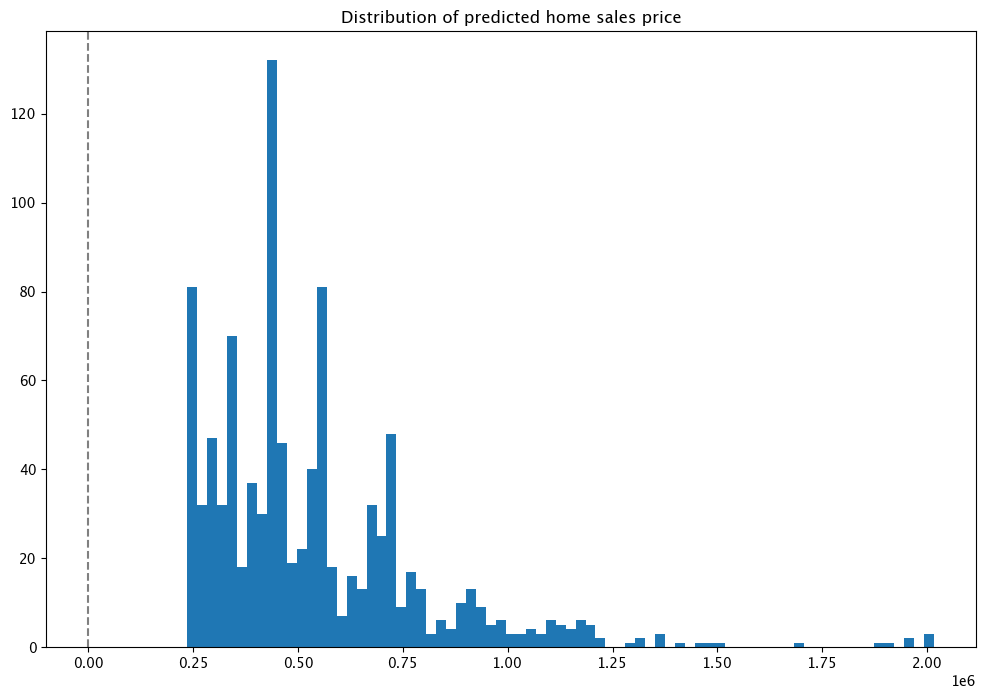

In [10]:
import matplotlib.pyplot as plt
houseprices = pd.DataFrame({'sell_price': large_inference_result['out.variable'].apply(lambda x: x[0])})

houseprices.hist(column='sell_price', bins=75, grid=False, figsize=(12,8))
plt.axvline(x=0, color='gray', ls='--')
_ = plt.title('Distribution of predicted home sales price')
time.sleep(5)
control_model_end = datetime.datetime.now()

### Pipeline Logs

Pipeline logs with standard pipeline steps are retrieved either with:

* Pipeline `logs` which returns either a pandas DataFrame or Apache Arrow table.
* Pipeline `export_logs` which saves the logs either a pandas DataFrame JSON file or Apache Arrow table.

For full details, see the Wallaroo Documentation Pipeline Log Management guide.

#### Pipeline Log Methods

The Pipeline `logs` method accepts the following parameters.

| **Parameter** | **Type** | **Description** |
|---|---|---|
| `limit` | **Int** (*Optional*) | Limits how many log records to display.  Defaults to `100`.  If there are more pipeline logs than are being displayed, the **Warning** message `Pipeline log record limit exceeded` will be displayed.  For example, if 100 log files were requested and there are a total of 1,000, the warning message will be displayed. |
| `start_datetimert` and `end_datetime` | **DateTime** (*Optional*) | Limits logs to all logs between the `start_datetime` and `end_datetime` DateTime parameters.  **Both parameters must be provided**. Submitting a `logs()` request with only `start_datetime` or `end_datetime` will generate an exception.<br />If `start_datetime` and `end_datetime` are provided as parameters, then the records are returned in **chronological** order, with the oldest record displayed first. |
| `arrow` | **Boolean** (*Optional*) | Defaults to **False**.  If `arrow` is set to `True`, then the logs are returned as an [Apache Arrow table](https://arrow.apache.org/).  If `arrow=False`, then the logs are returned as a pandas DataFrame. |

The following examples demonstrate displaying the logs, then displaying the logs between the `control_model_start` and `control_model_end` periods, then again retrieved as an Arrow table.

In [11]:
# pipeline log retrieval - reverse chronological order

display(mainpipeline.logs())

# pipeline log retrieval between two dates - chronological order

display(mainpipeline.logs(start_datetime=control_model_start, end_datetime=control_model_end))

# pipeline log retrieval limited to the last 5 an an arrow table

display(mainpipeline.logs(arrow=True))

,time,in.tensor,out.variable,anomaly.count
0,2024-07-29 21:02:01.575,"[4.0, 3.75, 4410.0, 8112.0, 3.0, 0.0, 4.0, 3.0, 11.0, 3570.0, 840.0, 47.5887985229, -122.391998291, 2770.0, 5750.0, 12.0, 0.0, 0.0]",[1967344.1],0
1,2024-07-29 21:02:01.575,"[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696014404, -122.2610015869, 3970.0, 20000.0, 79.0, 0.0, 0.0]",[1514079.4],0
2,2024-07-29 21:02:01.575,"[4.0, 3.0, 4750.0, 21701.0, 1.5, 0.0, 0.0, 5.0, 11.0, 4750.0, 0.0, 47.645401001, -122.2180023193, 3120.0, 18551.0, 38.0, 0.0, 0.0]",[2002393.6],0
3,2024-07-29 21:02:01.575,"[5.0, 4.25, 4860.0, 9453.0, 1.5, 0.0, 1.0, 5.0, 10.0, 3100.0, 1760.0, 47.6195983887, -122.2860031128, 3150.0, 8557.0, 109.0, 0.0, 0.0]",[1910824.0],0
4,2024-07-29 21:02:01.575,"[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696014404, -122.2610015869, 3970.0, 20000.0, 79.0, 0.0, 0.0]",[1514079.4],0
...,...,...,...,...
95,2024-07-29 21:02:01.575,"[3.0, 2.5, 5403.0, 24069.0, 2.0, 1.0, 4.0, 4.0, 12.0, 5403.0, 0.0, 47.4169006348, -122.3479995728, 3980.0, 104374.0, 39.0, 0.0, 0.0]",[1946437.8],0
96,2024-07-29 21:02:01.575,"[3.0, 2.5, 5403.0, 24069.0, 2.0, 1.0, 4.0, 4.0, 12.0, 5403.0, 0.0, 47.4169006348, -122.3479995728, 3980.0, 104374.0, 39.0, 0.0, 0.0]",[1946437.8],0
97,2024-07-29 21:02:01.575,"[4.0, 3.0, 3710.0, 20000.0, 2.0, 0.0, 2.0, 5.0, 10.0, 2760.0, 950.0, 47.6696014404, -122.2610015869, 3970.0, 20000.0, 79.0, 0.0, 0.0]",[1514079.4],0
98,2024-07-29 21:02:01.575,"[6.0, 4.0, 5310.0, 12741.0, 2.0, 0.0, 2.0, 3.0, 10.0, 3600.0, 1710.0, 47.5695991516, -122.2129974365, 4190.0, 12632.0, 48.0, 0.0, 0.0]",[2016006.1],0


,time,in.tensor,out.variable,anomaly.count
0,2024-07-29 21:06:35.483,"[4.0, 2.5, 2900.0, 5505.0, 2.0, 0.0, 0.0, 3.0, 8.0, 2900.0, 0.0, 47.6063, -122.02, 2970.0, 5251.0, 12.0, 0.0, 0.0]",[718013.7],0
1,2024-07-29 21:06:35.483,"[2.0, 2.5, 2170.0, 6361.0, 1.0, 0.0, 2.0, 3.0, 8.0, 2170.0, 0.0, 47.7109, -122.017, 2310.0, 7419.0, 6.0, 0.0, 0.0]",[615094.6],0
2,2024-07-29 21:06:35.483,"[3.0, 2.5, 1300.0, 812.0, 2.0, 0.0, 0.0, 3.0, 8.0, 880.0, 420.0, 47.5893, -122.317, 1300.0, 824.0, 6.0, 0.0, 0.0]",[448627.8],0
3,2024-07-29 21:06:35.483,"[4.0, 2.5, 2500.0, 8540.0, 2.0, 0.0, 0.0, 3.0, 9.0, 2500.0, 0.0, 47.5759, -121.994, 2560.0, 8475.0, 24.0, 0.0, 0.0]",[758714.3],0
4,2024-07-29 21:06:35.483,"[3.0, 1.75, 2200.0, 11520.0, 1.0, 0.0, 0.0, 4.0, 7.0, 2200.0, 0.0, 47.7659, -122.341, 1690.0, 8038.0, 62.0, 0.0, 0.0]",[513264.66],0
...,...,...,...,...
995,2024-07-29 21:06:35.483,"[3.0, 2.5, 2900.0, 23550.0, 1.0, 0.0, 0.0, 3.0, 10.0, 1490.0, 1410.0, 47.5708, -122.153, 2900.0, 19604.0, 27.0, 0.0, 0.0]",[827411.25],0
996,2024-07-29 21:06:35.483,"[4.0, 1.75, 2700.0, 7875.0, 1.5, 0.0, 0.0, 4.0, 8.0, 2700.0, 0.0, 47.454, -122.144, 2220.0, 7875.0, 46.0, 0.0, 0.0]",[441960.3],0
997,2024-07-29 21:06:35.483,"[4.0, 3.25, 2910.0, 1880.0, 2.0, 0.0, 3.0, 5.0, 9.0, 1830.0, 1080.0, 47.616, -122.282, 3100.0, 8200.0, 100.0, 0.0, 0.0]",[1060847.5],0
998,2024-07-29 21:06:35.483,"[3.0, 1.75, 2910.0, 37461.0, 1.0, 0.0, 0.0, 4.0, 7.0, 1530.0, 1380.0, 47.7015, -122.164, 2520.0, 18295.0, 47.0, 0.0, 0.0]",[706823.6],0


pyarrow.Table
time: timestamp[ms]
in.tensor: list<item: double>
  child 0, item: double
out.variable: list<inner: float not null> not null
  child 0, inner: float not null
anomaly.count: uint32 not null
----
time: [[2024-07-29 21:02:01.575,2024-07-29 21:02:01.575,2024-07-29 21:02:01.575,2024-07-29 21:02:01.575,2024-07-29 21:02:01.575,...,2024-07-29 21:02:01.575,2024-07-29 21:02:01.575,2024-07-29 21:02:01.575,2024-07-29 21:02:01.575,2024-07-29 21:02:01.575]]
in.tensor: [[[4,3.75,4410,8112,3,...,2770,5750,12,0,0],[4,3,3710,20000,2,...,3970,20000,79,0,0],...,[6,4,5310,12741,2,...,4190,12632,48,0,0],[4,3.75,4410,8112,3,...,2770,5750,12,0,0]]]
out.variable: [[[1967344.1],[1514079.4],...,[2016006.1],[1967344.1]]]
anomaly.count: [[0,0,0,0,0,...,0,0,0,0,0]]

## Anomaly Detection through Validations

Anomaly detection allows organizations to set validation parameters in a pipeline. A validation is added to a pipeline to test data based on an expression, and flag any inferences where the validation failed inference result and the pipeline logs.

Wallaroo provides **validations** to detect anomalous data from inference inputs and outputs.  Validations are added to a Wallaroo pipeline with the `wallaroo.pipeline.add_validations` method.

Adding validations takes the format:

```python
pipeline.add_validations(
    validation_name_01 = polars.col(in|out.{column_name}) EXPRESSION,
    validation_name_02 = polars.col(in|out.{column_name}) EXPRESSION
    ...{additional rules}
)
```

* `validation_name`: The user provided name of the validation.  The names must match Python variable naming requirements.
  * **IMPORTANT NOTE**: Using the name `count` as a validation name **returns a warning**.  Any validation rules named `count` are dropped upon request and an warning returned.
* `polars.col(in|out.{column_name})`: Specifies the **input** or **output** for a specific field aka "column" in an inference result.  Wallaroo inference requests are in the format `in.{field_name}` for **inputs**, and `out.{field_name}` for **outputs**.
  * More than one field can be selected, as long as they follow the rules of the [polars 0.18 Expressions library](https://docs.pola.rs/docs/python/version/0.18/reference/expressions/index.html).
* `EXPRESSION`:  The expression to validate. When the expression returns **True**, that indicates an anomaly detected.

The [`polars` library version 0.18.5](https://docs.pola.rs/docs/python/version/0.18/index.html) is used to create the validation rule.  This is installed by default with the Wallaroo SDK.  This provides a powerful range of comparisons to organizations tracking anomalous data from their ML models.

When validations are added to a pipeline, inference request outputs return the following fields:

| Field | Type | Description |
|---|---|---|
| **anomaly.count** | **Integer** | The total of all validations that returned **True**. |
| **anomaly.{validation name}** | **Bool** | The output of the validation `{validation_name}`. |

When validation returns `True`, **an anomaly is detected**.

In [13]:
import polars as pl

## Add the validation to the pipeline

mainpipeline = mainpipeline.add_validations(
    too_high=pl.col("out.variable").list.get(0) > 1500000.0
)

#minimum deployment config
deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(0.5).memory("1Gi").build()
mainpipeline.deploy(deployment_config = deploy_config)

name,housepricesagapipeline
created,2024-07-29 20:54:17.194002+00:00
last_updated,2024-07-29 21:07:10.611862+00:00
deployed,True
workspace_id,11
workspace_name,housepricesagaworkspace
arch,x86
accel,none
tags,
versions,"7c6a0806-840d-4699-a29a-940d8ba27922, c419432b-0706-4b52-9f7f-4533d849fc10, c320d229-bafb-430b-924e-71c770075d18, e0332b43-4ce6-4844-bfa2-d3afbdcba346, c00e3993-9d43-4865-b107-3f58744d683b"
steps,housepricesagacontrol


### Validation Testing

Two validations will be tested:

* One that should return a house value lower than 1,500,000.  The validation will pass so `check_failure` will be 0.
* The other than should return a house value greater than 1,500,000.  The validation will fail, so `check_failure` will be 1.

In [14]:
validation_start = datetime.datetime.now()

# Small value home

normal_input = pd.DataFrame.from_records({
        "tensor": [[
            3.0,
            2.25,
            1620.0,
            997.0,
            2.5,
            0.0,
            0.0,
            3.0,
            8.0,
            1540.0,
            80.0,
            47.5400009155,
            -122.0260009766,
            1620.0,
            1068.0,
            4.0,
            0.0,
            0.0
        ]]
    }
)

small_result = mainpipeline.infer(normal_input)

display(small_result.loc[:,["time", "out.variable", "anomaly.count", "anomaly.too_high"]])

,time,out.variable,anomaly.count,anomaly.too_high
0,2024-07-29 21:07:15.616,[544392.06],0,False


In [16]:
# Big value home

big_input = pd.DataFrame.from_records({
        "tensor": [[
            4.0,
            4.5,
            5770.0,
            10050.0,
            1.0,
            0.0,
            3.0,
            5.0,
            9.0,
            3160.0,
            2610.0,
            47.6769981384,
            -122.2750015259,
            2950.0,
            6700.0,
            65.0,
            0.0,
            0.0
        ]]
    }
)

big_result = mainpipeline.infer(big_input)

display(big_result.loc[:,["time", "out.variable", "anomaly.count", "anomaly.too_high"]])

,time,out.variable,anomaly.count,anomaly.too_high
0,2024-07-29 21:07:46.014,[1689843.1],1,True


### Anomaly Results

We'll run through our previous batch, this time showing only those results outside of the validation, and a graph showing where the anomalies are against the other results.

In [17]:
batch_inferences = mainpipeline.infer_from_file('./data/xtest-1k.arrow')

large_inference_result =  batch_inferences.to_pandas()
# Display only the anomalous results

display(large_inference_result[large_inference_result["anomaly.too_high"] > 0].loc[:,["time", "out.variable", "anomaly.too_high"]])

,time,out.variable,anomaly.too_high
30,2024-07-29 21:07:51.364,[1514079.4],True
248,2024-07-29 21:07:51.364,[1967344.1],True
255,2024-07-29 21:07:51.364,[2002393.6],True
556,2024-07-29 21:07:51.364,[1886959.2],True
698,2024-07-29 21:07:51.364,[1689843.1],True
711,2024-07-29 21:07:51.364,[1946437.8],True
722,2024-07-29 21:07:51.364,[2005883.1],True
782,2024-07-29 21:07:51.364,[1910824.0],True
965,2024-07-29 21:07:51.364,[2016006.1],True


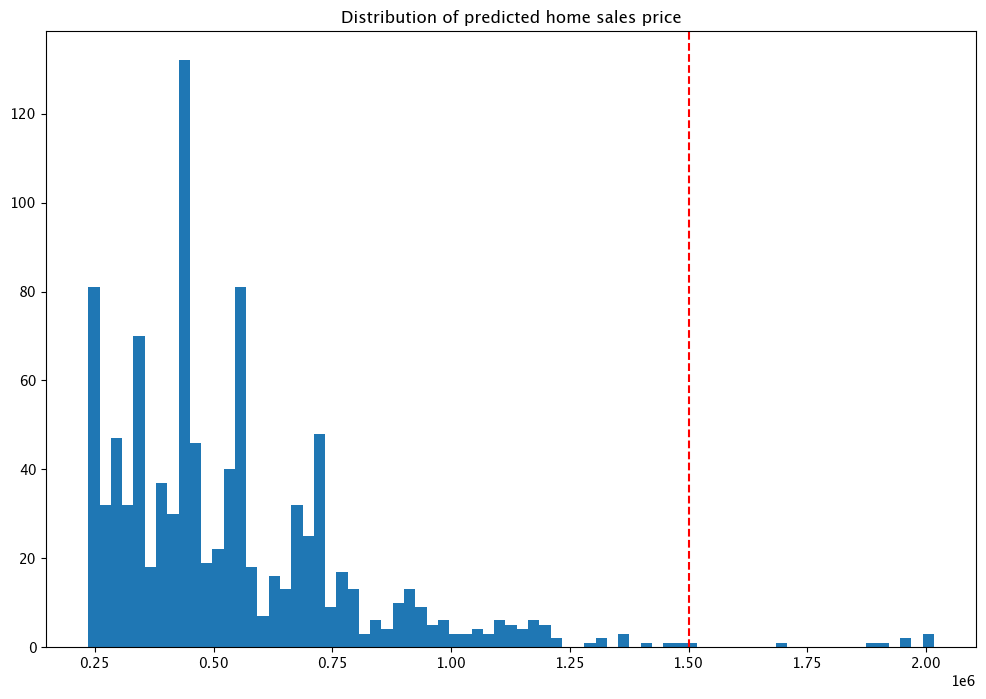

In [18]:
import matplotlib.pyplot as plt
houseprices = pd.DataFrame({'sell_price': large_inference_result['out.variable'].apply(lambda x: x[0])})

houseprices.hist(column='sell_price', bins=75, grid=False, figsize=(12,8))
plt.axvline(x=1500000, color='red', ls='--')
_ = plt.title('Distribution of predicted home sales price')

## Assays

Wallaroo assays provide a method for detecting input or model drift.  These can be triggered either when unexpected input is provided for the inference, or when the model needs to be retrained from changing environment conditions.

Wallaroo assays can track either an input field and its index, or an output field and its index.  For full details, see the [Wallaroo Assays Management Guide](https://docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-pipeline-management/wallaroo-pipeline-assays/).

For this example, we will:

* Perform sample inferences based on lower priced houses.
* Create an assay with the baseline set off those lower priced houses.
* Generate inferences spread across all house values, plus specific set of high priced houses to trigger the assay alert.
* Run an interactive assay to show the detection of values outside the established baseline.

### Assay Generation

To start the demonstration, we'll create a baseline of values from houses with small estimated prices and set that as our baseline. Assays are typically run on a 24 hours interval based on a 24 hour window of data, but we'll bypass that by setting our baseline time even shorter.

In [31]:
assay_baseline_start = datetime.datetime.now()
small_houses_inputs = pd.read_json('./data/smallinputs.df.json')
baseline_size = 500


# Where the baseline data will start
baseline_start = datetime.datetime.now()

# These inputs will be random samples of small priced houses.  Around 30,000 is a good number
small_houses = small_houses_inputs.sample(baseline_size, replace=True).reset_index(drop=True)

small_results = mainpipeline.infer(small_houses)

# Set the baseline end

baseline_end = datetime.datetime.now()

In [32]:
# turn the inference results into a numpy array for the baseline

# set the results to a non-array value
small_results_baseline_df = small_results.copy()
small_results_baseline_df['variable']=small_results['out.variable'].map(lambda x: x[0])

# get the numpy values
small_results_baseline = small_results_baseline_df['variable'].to_numpy()

In [33]:
assay_baseline_from_numpy_name = "house price saga assay from numpy"

# assay builder by baseline
assay_builder_from_numpy = wl.build_assay(assay_name=assay_baseline_from_numpy_name, 
                               pipeline=mainpipeline,
                               iopath="output variable 0", 
                               baseline_data = small_results_baseline)

In [37]:
assay_window_end = datetime.datetime.now()
assay_builder_from_numpy.add_run_until(assay_window_end)
assay_builder_from_numpy.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_baseline_start)
assay_config_from_numpy = assay_builder_from_numpy.build()
assay_analysis_from_numpy = assay_config_from_numpy.interactive_run()

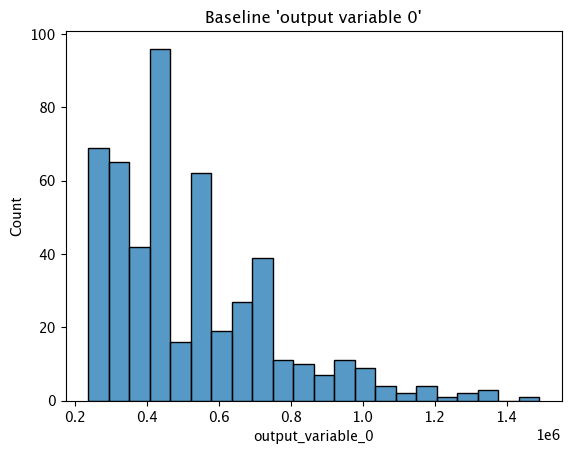

In [38]:
# get the histogram from the numpy baseline
assay_builder_from_numpy.baseline_histogram()

In [39]:
# show the baseline stats
assay_analysis_from_numpy[0].baseline_stats()


,Baseline
count,500
min,236238.67
max,1489624.3
mean,520219.25232
median,449163.84
std,226582.099937
start,None
end,None


Now we'll perform some inferences with a spread of values, then a larger set with a set of larger house values to trigger our assay alert.

Because our assay windows are 1 minutes, we'll need to stagger our inference values to be set into the proper windows.  This will take about 4 minutes.

By default, assay start date is set to 24 hours from when the assay was created.  For this example, we will set the `assay.window_builder.add_start` to set the assay window to start at the beginning of our data, and `assay.add_run_until` to set the time period to stop gathering data from.

In [40]:
# Get a spread of house values

time.sleep(35)
# regular_houses_inputs = pd.read_json('./data/xtest-1k.df.json', orient="records")
inference_size = 1000

# regular_houses = regular_houses_inputs.sample(inference_size, replace=True).reset_index(drop=True)

# And a spread of large house values

big_houses_inputs = pd.read_json('./data/biginputs.df.json', orient="records")
big_houses = big_houses_inputs.sample(inference_size, replace=True).reset_index(drop=True)

# Set the start for our assay window period.
assay_window_start = datetime.datetime.now()

mainpipeline.infer(big_houses)


# End our assay window period
time.sleep(35)
assay_window_end = datetime.datetime.now()

In [41]:
assay_window_end = datetime.datetime.now()
assay_builder_from_numpy.add_run_until(assay_window_end)
assay_builder_from_numpy.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_baseline_start)
assay_config_from_numpy = assay_builder_from_numpy.build()
assay_analysis_from_numpy = assay_config_from_numpy.interactive_run()

Generated 2 analyses


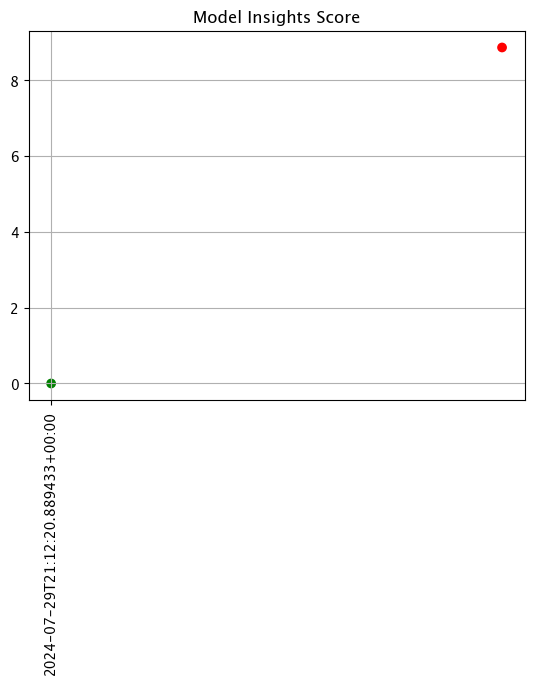

In [42]:
# Show how many assay windows were analyzed, then show the chart
print(f"Generated {len(assay_analysis_from_numpy)} analyses")
assay_analysis_from_numpy.chart_scores()

In [43]:
# Display the results as a DataFrame - we're mainly interested in the score and whether the 
# alert threshold was triggered
display(assay_analysis_from_numpy.to_dataframe().loc[:, ["score", "start", "alert_threshold", "status"]])

,score,start,alert_threshold,status
0,0.00000,2024-07-29T21:12:20.889433+00:00,0.25,Ok
1,8.87099,2024-07-29T21:14:20.889433+00:00,0.25,Alert


The assay is now visible through the Wallaroo UI by selecting the workspace, then the pipeline, then **Insights**.

![Sample assay in the UI](./images/housepricesaga-sample-assay.png)

## Shadow Deploy

Let's assume that after analyzing the assay information we want to test two challenger models to our control.  We do that with the Shadow Deploy pipeline step.

In Shadow Deploy, the pipeline step is added with the `add_shadow_deploy` method, with the champion model listed first, then an array of challenger models after.  **All** inference data is fed to **all** models, with the champion results displayed in the `out.variable` column, and the shadow results in the format `out_{model name}.variable`.  For example, since we named our challenger models `housingchallenger01` and `housingchallenger02`, the columns `out_housingchallenger01.variable` and `out_housingchallenger02.variable` have the shadow deployed model results.

For this example, we will remove the previous pipeline step, then replace it with a shadow deploy step with `rf_model.onnx` as our champion, and models `xgb_model.onnx` and `gbr_model.onnx` as the challengers.  We'll deploy the pipeline and prepare it for sample inferences.

In [49]:
# Upload the challenger models

model_name_challenger01 = 'housingchallenger01'
model_file_name_challenger01 = './models/xgb_model.onnx'

model_name_challenger02 = 'housingchallenger02'
model_file_name_challenger02 = './models/gbr_model.onnx'

housing_model_challenger01 = (wl.upload_model(model_name_challenger01, 
                                              model_file_name_challenger01, 
                                              framework=Framework.ONNX)
                                              .configure(tensor_fields=["tensor"])
                            )
housing_model_challenger02 = (wl.upload_model(model_name_challenger02, 
                                              model_file_name_challenger02, 
                                              framework=Framework.ONNX)
                                              .configure(tensor_fields=["tensor"])
                            )

In [50]:
# Undeploy the pipeline
mainpipeline.undeploy()
mainpipeline.clear()
# Add the new shadow deploy step with our challenger models
mainpipeline.add_shadow_deploy(housing_model_control, [housing_model_challenger01, housing_model_challenger02])

# Deploy the pipeline with the new shadow step
#minimum deployment config
deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(0.5).memory("1Gi").build()
mainpipeline.deploy(deployment_config = deploy_config)

name,housepricesagapipeline
created,2024-07-29 20:54:17.194002+00:00
last_updated,2024-07-29 21:18:00.553970+00:00
deployed,True
workspace_id,11
workspace_name,housepricesagaworkspace
arch,x86
accel,none
tags,
versions,"0b0ac730-5253-40c4-b0e4-06d2a1ec1808, 7c6a0806-840d-4699-a29a-940d8ba27922, c419432b-0706-4b52-9f7f-4533d849fc10, c320d229-bafb-430b-924e-71c770075d18, e0332b43-4ce6-4844-bfa2-d3afbdcba346, c00e3993-9d43-4865-b107-3f58744d683b"
steps,housepricesagacontrol


### Shadow Deploy Sample Inference

We'll now use our same sample data for an inference to our shadow deployed pipeline, then display the first 20 results with just the comparative outputs.

In [51]:
shadow_result = mainpipeline.infer_from_file('./data/xtest-1k.arrow')

shadow_outputs =  shadow_result.to_pandas()
display(shadow_outputs.loc[0:20,['out.variable','out_housingchallenger01.variable','out_housingchallenger02.variable']])

,out.variable,out_housingchallenger01.variable,out_housingchallenger02.variable
0,[718013.7],[659806.0],[704901.9]
1,[615094.6],[732883.5],[695994.44]
2,[448627.8],[419508.84],[416164.8]
3,[758714.3],[634028.75],[655277.2]
4,[513264.66],[427209.47],[426854.66]
5,[668287.94],[615501.9],[632556.06]
6,[1004846.56],[1139732.4],[1100465.2]
7,[684577.25],[498328.88],[528278.06]
8,[727898.25],[722664.4],[659439.94]
9,[559631.06],[525746.44],[534331.44]


## A/B Testing

A/B Testing is another method of comparing and testing models.  Like shadow deploy, multiple models are compared against the champion or control models.  The difference is that instead of submitting the inference data to all models, then tracking the outputs of all of the models, the inference inputs are off of a ratio and other conditions.

For this example, we'll be using a 1:1:1 ratio with a random split between the champion model and the two challenger models.  Each time an inference request is made, there is a random equal chance of any one of them being selected.

When the inference results and log entries are displayed, they include the column `out._model_split` which displays:

| Field | Type | Description |
|---|---|---|
| `name` | String | The model name used for the inference.  |
| `version` | String| The version of the model. |
| `sha` | String | The sha hash of the model version. |

This is used to determine which model was used for the inference request.


In [53]:
# remove the shadow deploy steps
mainpipeline.undeploy()
mainpipeline.clear()

# Add the a/b test step to the pipeline
mainpipeline.add_random_split([(1, housing_model_control), 
                               (1, housing_model_challenger01), 
                               (1, housing_model_challenger02)], 
                               "session_id")

mainpipeline.deploy()

name,housepricesagapipeline
created,2024-07-29 20:54:17.194002+00:00
last_updated,2024-07-29 21:19:58.198107+00:00
deployed,True
workspace_id,11
workspace_name,housepricesagaworkspace
arch,x86
accel,none
tags,
versions,"5cf4a748-c809-4d9e-86e9-cb8782ffc841, 826a89ab-e527-4895-8cf1-e47761751106, 0b0ac730-5253-40c4-b0e4-06d2a1ec1808, 7c6a0806-840d-4699-a29a-940d8ba27922, c419432b-0706-4b52-9f7f-4533d849fc10, c320d229-bafb-430b-924e-71c770075d18, e0332b43-4ce6-4844-bfa2-d3afbdcba346, c00e3993-9d43-4865-b107-3f58744d683b"
steps,housepricesagacontrol


In [70]:
# Perform sample inferences of 20 rows and display the results
ab_date_start = datetime.datetime.now()
abtesting_inputs = pd.read_json('./data/xtest-1k.df.json')

df = pd.DataFrame(columns=["model", "value"])

for index, row in abtesting_inputs.sample(20).iterrows():
    result = mainpipeline.infer(row.to_frame('tensor').reset_index())
    value = result.loc[0]["out.variable"]
    model = json.loads(result.loc[0]["out._model_split"][0])["model_version"]["name"]
    df = df.append({'model': model, 'value': value}, ignore_index=True)

display(df)
ab_date_end = datetime.datetime.now()

,model,value
0,housingchallenger01,[660564.44]
1,housingchallenger01,[374125.22]
2,housingchallenger01,[491076.16]
3,housepricesagacontrol,[673288.6]
4,housingchallenger02,[498780.4]
5,housingchallenger01,[587826.75]
6,housepricesagacontrol,[677870.8]
7,housingchallenger01,[327746.38]
8,housepricesagacontrol,[536371.2]
9,housingchallenger02,[262815.56]


## Model Swap

Now that we've completed our testing, we can swap our deployed model in the original `housepricingpipeline` with one we feel works better.

We'll start by removing the A/B Testing pipeline step, then going back to the single pipeline step with the champion model and perform a test inference.

When going from a testing step such as A/B Testing or Shadow Deploy, it is best to undeploy the pipeline, change the steps, then deploy the pipeline.  In a production environment, there should be two pipelines:  One for production, the other for testing models.  Since this example uses one pipeline for simplicity, we will undeploy our main pipeline and reset it back to a one-step pipeline with the current champion model as our pipeline step.

Once done, we'll perform the hot swap with the model `gbr_model.onnx`, which was labeled `housing_model_challenger02` in a previous step.  We'll do an inference with the same data as used with the challenger model.  Note that previously, the inference through the original model returned `[718013.7]`.

In [71]:
mainpipeline.undeploy()

# remove the shadow deploy steps
mainpipeline.clear()

mainpipeline.add_model_step(housing_model_control).deploy()

# Inference test
normal_input = pd.DataFrame.from_records({"tensor": [[4.0,
            2.25,
            2200.0,
            11250.0,
            1.5,
            0.0,
            0.0,
            5.0,
            7.0,
            1300.0,
            900.0,
            47.6845,
            -122.201,
            2320.0,
            10814.0,
            94.0,
            0.0,
            0.0]]})
controlresult = mainpipeline.infer(normal_input)
display(controlresult)

,time,in.tensor,out.variable,anomaly.count
0,2024-07-29 21:29:11.454,"[4.0, 2.25, 2200.0, 11250.0, 1.5, 0.0, 0.0, 5.0, 7.0, 1300.0, 900.0, 47.6845, -122.201, 2320.0, 10814.0, 94.0, 0.0, 0.0]",[682284.56],0


Now we'll "hot swap" the control model.  We don't have to deploy the pipeline - we can just swap the model out in that pipeline step and continue with only a millisecond or two lost while the swap was performed.

In [72]:
# Perform hot swap

mainpipeline.replace_with_model_step(0, housing_model_challenger02).deploy()
# wait a moment for the database to be updated.  The swap is near instantaneous but database writes may take a moment
import time
time.sleep(15)

# inference after model swap
normal_input = pd.DataFrame.from_records({"tensor": [[4.0,
            2.25,
            2200.0,
            11250.0,
            1.5,
            0.0,
            0.0,
            5.0,
            7.0,
            1300.0,
            900.0,
            47.6845,
            -122.201,
            2320.0,
            10814.0,
            94.0,
            0.0,
            0.0]]})
challengerresult = mainpipeline.infer(normal_input)
display(challengerresult)

,time,in.tensor,out.variable,anomaly.count
0,2024-07-29 21:29:27.791,"[4.0, 2.25, 2200.0, 11250.0, 1.5, 0.0, 0.0, 5.0, 7.0, 1300.0, 900.0, 47.6845, -122.201, 2320.0, 10814.0, 94.0, 0.0, 0.0]",[770916.6],0


In [73]:
# Display the difference between the two

display(f'Original model output: {controlresult.loc[0]["out.variable"]}')
display(f'Hot swapped model  output: {challengerresult.loc[0]["out.variable"]}')

'Original model output: [682284.56]'

'Hot swapped model  output: [770916.6]'

### Undeploy Main Pipeline

With the examples and tutorial complete, we will undeploy the main pipeline and return the resources back to the Wallaroo instance.

In [74]:
mainpipeline.undeploy()

name,housepricesagapipeline
created,2024-07-29 20:54:17.194002+00:00
last_updated,2024-07-29 21:29:11.637647+00:00
deployed,False
workspace_id,11
workspace_name,housepricesagaworkspace
arch,x86
accel,none
tags,
versions,"faa39ef7-1fa7-4fa8-806a-d0e857a984eb, b43766ec-b5e1-4d15-bf19-d89d49161e54, 5cf4a748-c809-4d9e-86e9-cb8782ffc841, 826a89ab-e527-4895-8cf1-e47761751106, 0b0ac730-5253-40c4-b0e4-06d2a1ec1808, 7c6a0806-840d-4699-a29a-940d8ba27922, c419432b-0706-4b52-9f7f-4533d849fc10, c320d229-bafb-430b-924e-71c770075d18, e0332b43-4ce6-4844-bfa2-d3afbdcba346, c00e3993-9d43-4865-b107-3f58744d683b"
steps,housingchallenger02
